In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.power import tt_ind_solve_power

import numpy as np
from scipy.stats import mannwhitneyu
from statannotations.Annotator import Annotator

# plot settings 
sns.set_style('whitegrid')

In [3]:
# Pilot Study Analysis
df = pd.read_csv("data/Surge-P3.csv")
df.head()
df.columns = df.columns.map(lambda x: "".join(x.split(" ")))
df = df[df['Status'].isin(['COMPLETE'])]

df['PriorAsync'] = df['HaveyouusedthePythonAsynciolibrarybefore?']
df['CodingExpertiseAll'] = df['Howmanyyearsofcodingexperiencedoyouhave?']
expertise_map = {
    '1-3 years': 1, 
    '4-6 years': 2,
    '7+ years': 3,
}

df['CodingExpertise'] = df['CodingExpertiseAll'].map(expertise_map)
df["Treatment"] = df["Condition"].map({"AI": 0, "No AI": 1})
df["TimePerTask"] = df["TaskTime"] / df["TasksComplete"]
df['QuizScorePercent'] = 100*df['QuizScore'] / 27
pvals = [] 
for outcome in ['QuizScore', 'TaskTime']:

    # calculate Cohen's d
    ai_scores = df[df['Treatment'] == 0][outcome]
    no_ai_scores = df[df['Treatment'] == 1][outcome]

    n1, n2 = len(ai_scores), len(no_ai_scores)
    var1, var2 = ai_scores.var(ddof=1), no_ai_scores.var(ddof=1)
    pooled_sd = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))

    # Cohen's d
    cohens_d = (no_ai_scores.mean() - ai_scores.mean()) / pooled_sd
    print(f"Cohen's d: {cohens_d:.3f}")


    # covariates: PreQuizAsync, CodingExpertise, PriorAsync
    model = smf.ols(f'{outcome} ~ Treatment', data=df).fit()
    print(model.summary())

    condition_coef = model.params['Treatment']
    residual_std = np.sqrt(model.mse_resid)

    # Calculate adjusted Cohen's d based on covariates
    adjusted_d = condition_coef / residual_std
    print(f"Condition coefficient: {condition_coef:.3f}")
    print(f"Adjusted Cohen's d: {adjusted_d:.3f}")

    n = tt_ind_solve_power(effect_size=adjusted_d, nobs1=None, ratio=1, alpha=0.05, power=0.8)
    print("effect_size", adjusted_d, "n", n)
    pvals.append(model.pvalues['Treatment'])

Cohen's d: 1.669
                            OLS Regression Results                            
Dep. Variable:              QuizScore   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     12.38
Date:                Thu, 14 Aug 2025   Prob (F-statistic):            0.00285
Time:                        22:06:10   Log-Likelihood:                -42.729
No. Observations:                  18   AIC:                             89.46
Df Residuals:                      16   BIC:                             91.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2500      0.974   

/Users/jhs/Code/AFP/skill-dev/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Users/jhs/Code/AFP/skill-dev/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [19]:
def format_pval(pval):
    if pval < 0.001:
        return f'p = {pval:.3f}***'
    elif pval < 0.01:
        return f'p = {pval:.3f}**'
    elif pval < 0.05:
        return f'p = {pval:.3f}*'
    else:
        return f'p = {pval:.3f}'

In [30]:
df['QuizScore'].std()

np.float64(3.5609767698702495)

['p = 0.003**', 'p = 0.033*']
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI vs. No AI: p = 0.033*
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI vs. No AI: p = 0.003**


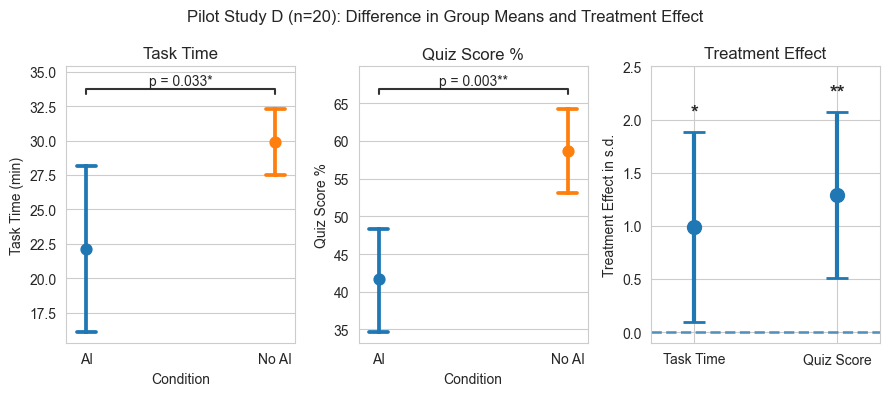

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(9, 4))
sns.pointplot(df, x="Condition", y="TaskTime", errorbar="ci", ax=ax[0], capsize=0.1, linestyle="", hue="Condition").set_ylabel("Task Time (min)")
sns.pointplot(df, x="Condition", y="QuizScorePercent", errorbar="ci", ax=ax[1], capsize=0.1, linestyle="", hue="Condition").set_ylabel("Quiz Score %")
ax[0].set_title("Task Time")
ax[1].set_title("Quiz Score %")

OUTCOMES = ['Task Time', 'Quiz Score']
for i, outcome in enumerate(['TaskTime', 'QuizScore']):
    plot_df = df.copy()
    plot_df[f'{outcome}_std'] = plot_df[outcome] / plot_df[outcome].std()
    model = smf.ols(f'{outcome}_std ~ Treatment', data=plot_df).fit()
    treatment_effect = model.params['Treatment']
    ci_lower, ci_upper = model.conf_int().loc['Treatment']
    p_value = model.pvalues['Treatment']

    # Plot the treatment effect with confidence intervals
    ax[2].errorbar([i], [treatment_effect], 
            yerr=[[treatment_effect - ci_lower], [ci_upper - treatment_effect]], 
            fmt='o', capsize=8, capthick=2, markersize=10, linewidth=3, color=sns.color_palette()[0])
    
    # Add significance stars
    if p_value < 0.001:
        stars = '***'
    elif p_value < 0.01:
        stars = '**'
    elif p_value < 0.05:
        stars = '*'
    else:
        stars = ''
    
    if stars:
        ax[2].text(i, ci_upper + 0.1, stars, ha='center', va='bottom', fontsize=14, fontweight='bold')

ax[2].set_xticks([0, 1])
ax[2].set_xticklabels(OUTCOMES)
ax[2].set_xlim(-0.3, 1.3)
ax[2].set_ylim(-0.1, 2.5)
ax[2].set_ylabel("Treatment Effect in s.d.")
ax[2].set_title("Treatment Effect")
ax[2].axhline(y=0, color=sns.color_palette()[0], linestyle='--', alpha=0.7, linewidth=2)

# # Add asterisk annotation to indicate significance
# ax[0].text(-0.7, 0.95, '*p < 0.05', transform=ax[1].transAxes, ha='center', va='top', fontsize=12)
# ax[1].text(0.5, 0.95, '*p < 0.05', transform=ax[1].transAxes, ha='center', va='top', fontsize=12)
pairs = [("AI", "No AI")]
formatted_pvals = [format_pval(pval) for pval in pvals]
plotting_params = {
    'data': df, 
    'x': 'Condition', 
    'y': 'TaskTime', 
}
print(formatted_pvals)

annotator = Annotator(ax=ax[0], pairs=pairs, **plotting_params)
annotator.set_custom_annotations([formatted_pvals[1]])
annotator.annotate()

annotator = Annotator(ax=ax[1], pairs=pairs, **plotting_params)
annotator.set_custom_annotations([formatted_pvals[0]])
annotator.annotate()


plt.suptitle("Pilot Study D (n=20): Difference in Group Means and Treatment Effect")
plt.tight_layout()

In [46]:
# load data and 1 time data transformations 
df = pd.read_csv("data/Full-Study.csv")
df.columns = df.columns.map(lambda x: "".join(x.split(" ")))
print(df.STATUS.value_counts())
df = df[df['STATUS'].isin(['COMPLETED', 'TIME-1N', 'TIME-2N', 'TIME-3N'])]

df['PriorAsync'] = df['HaveyouusedthePythonAsynciolibrarybefore?']
df['QuizScorePercent'] = 100*df['QuizScore'] / 27
df['CodingExpertiseAll'] = df['Howmanyyearsofcodingexperiencedoyouhave?']
expertise_map = {
    '1-3 years': 1, 
    '4-6 years': 2,
    '7+ years': 3,
}

df['CodingExpertise'] = df['CodingExpertiseAll'].map(expertise_map)
df['CodingExpertiseBin'] = df['CodingExpertiseAll'].apply(lambda x: '7+ years' if x == '7+ years' else '<7 years')
df["Treatment"] = df["Condition"].map({"AI": 0, "No AI": 1})

STATUS
COMPLETED     45
INCOMPLETE     5
TIME-1N        3
TIME-2N        2
TIME-3N        2
TIME-4N        1
Name: count, dtype: int64


['p = 0.391', 'p = 0.010*']
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI vs. No AI: p = 0.391
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI vs. No AI: p = 0.010*


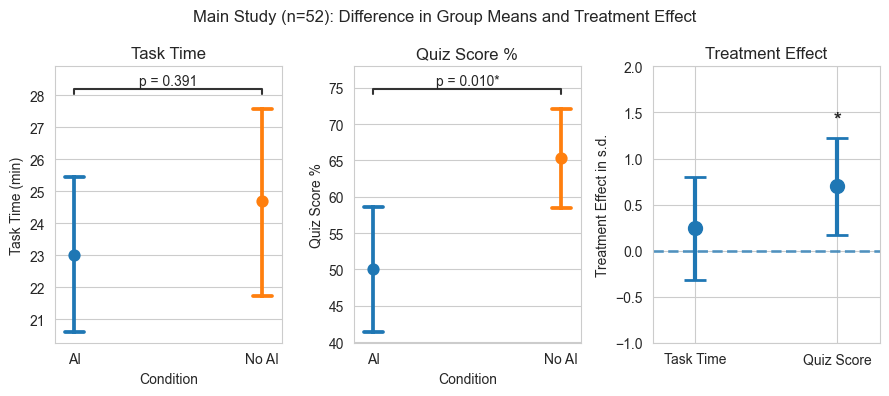

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(9, 4))
sns.pointplot(df, x="Condition", y="TaskTime", errorbar="ci", ax=ax[0], capsize=0.1, linestyle="", hue="Condition").set_ylabel("Task Time (min)")
sns.pointplot(df, x="Condition", y="QuizScorePercent", errorbar="ci", ax=ax[1], capsize=0.1, linestyle="", hue="Condition").set_ylabel("Quiz Score %")
ax[0].set_title("Task Time")
ax[1].set_title("Quiz Score %")

OUTCOMES = ['Task Time', 'Quiz Score']
pvals = []
for i, outcome in enumerate(['TaskTime', 'QuizScore']):
    plot_df = df.copy()
    plot_df[f'{outcome}_std'] = plot_df[outcome] / plot_df[outcome].std()
    model = smf.ols(f'{outcome}_std ~ Treatment', data=plot_df).fit()
    treatment_effect = model.params['Treatment']
    ci_lower, ci_upper = model.conf_int().loc['Treatment']
    p_value = model.pvalues['Treatment']
    pvals.append(p_value)
    # Plot the treatment effect with confidence intervals
    ax[2].errorbar([i], [treatment_effect], 
            yerr=[[treatment_effect - ci_lower], [ci_upper - treatment_effect]], 
            fmt='o', capsize=8, capthick=2, markersize=10, linewidth=3, color=sns.color_palette()[0])
    
    # Add significance stars
    if p_value < 0.001:
        stars = '***'
    elif p_value < 0.01:
        stars = '**'
    elif p_value < 0.05:
        stars = '*'
    else:
        stars = ''
    
    if stars:
        ax[2].text(i, ci_upper + 0.1, stars, ha='center', va='bottom', fontsize=14, fontweight='bold')

ax[2].set_xticks([0, 1])
ax[2].set_xticklabels(OUTCOMES)
ax[2].set_xlim(-0.3, 1.3)
ax[2].set_ylim(-1, 2)
ax[2].set_ylabel("Treatment Effect in s.d.")
ax[2].set_title("Treatment Effect")
ax[2].axhline(y=0, color=sns.color_palette()[0], linestyle='--', alpha=0.7, linewidth=2)

# # Add asterisk annotation to indicate significance
# ax[0].text(-0.7, 0.95, '*p < 0.05', transform=ax[1].transAxes, ha='center', va='top', fontsize=12)
# ax[1].text(0.5, 0.95, '*p < 0.05', transform=ax[1].transAxes, ha='center', va='top', fontsize=12)
pairs = [("AI", "No AI")]
formatted_pvals = [format_pval(pval) for pval in pvals]
plotting_params = {
    'data': df, 
    'x': 'Condition', 
    'y': 'TaskTime', 
}
print(formatted_pvals)

annotator = Annotator(ax=ax[0], pairs=pairs, **plotting_params)
annotator.set_custom_annotations([formatted_pvals[0]])
annotator.annotate()

annotator = Annotator(ax=ax[1], pairs=pairs, **plotting_params)
annotator.set_custom_annotations([formatted_pvals[1]])
annotator.annotate()


plt.suptitle("Main Study (n=52): Difference in Group Means and Treatment Effect")
plt.tight_layout()

In [135]:
# Pilot Power Analysis

# select 'QuizScore' or 'TaskTime'
outcome = 'QuizScorePercent' 

# calculate Cohen's d
ai_scores = df[df['Treatment'] == 0][outcome]
no_ai_scores = df[df['Treatment'] == 1][outcome]

n1, n2 = len(ai_scores), len(no_ai_scores)
var1, var2 = ai_scores.var(ddof=1), no_ai_scores.var(ddof=1)
pooled_sd = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))

# Cohen's d
cohens_d = (no_ai_scores.mean() - ai_scores.mean()) / pooled_sd
print(f"Cohen's d: {cohens_d:.3f}")


# covariates: PreQuizAsync, CodingExpertise, PriorAsync
model = smf.ols(f'{outcome} ~ Treatment + WarmupTaskTime', data=df).fit()
print(model.summary())


condition_coef = model.params['Treatment']
residual_std = np.sqrt(model.mse_resid)

# Calculate adjusted Cohen's d based on covariates
adjusted_d = condition_coef / residual_std
print(f"Condition coefficient: {condition_coef:.3f}")
print(f"Adjusted Cohen's d: {adjusted_d:.3f}")

n = tt_ind_solve_power(effect_size=adjusted_d, nobs1=None, ratio=1, alpha=0.05, power=0.8)
print("effect_size", adjusted_d, "n", n)

Cohen's d: 0.738
                            OLS Regression Results                            
Dep. Variable:       QuizScorePercent   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     4.164
Date:                Thu, 14 Aug 2025   Prob (F-statistic):             0.0216
Time:                        15:14:40   Log-Likelihood:                -221.94
No. Observations:                  50   AIC:                             449.9
Df Residuals:                      47   BIC:                             455.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         55.7756  

['p = 0.870', 'p = 0.619', 'p = 0.204']
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

4-6 years_AI vs. 4-6 years_No AI: p = 0.619
7+ years_AI vs. 7+ years_No AI: p = 0.870
1-3 years_AI vs. 1-3 years_No AI: p = 0.204
['p = 0.124', 'p = 0.038*', 'p = 0.807']
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

4-6 years_AI vs. 4-6 years_No AI: p = 0.038*
7+ years_AI vs. 7+ years_No AI: p = 0.124
1-3 years_AI vs. 1-3 years_No AI: p = 0.807


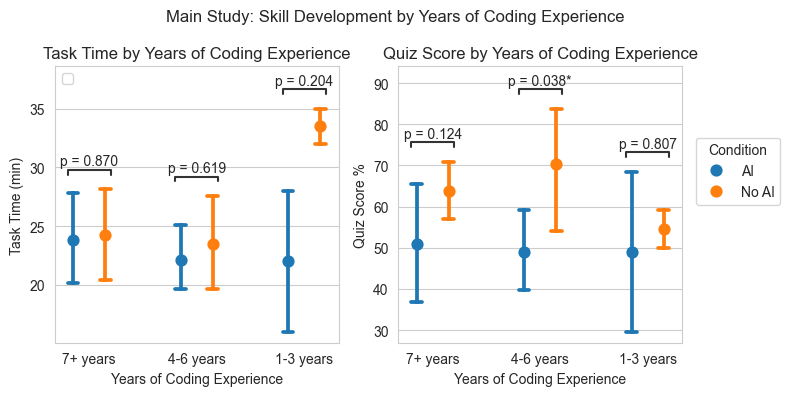

In [76]:
# TaskTime vs QuizScore
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
axes = ax.flatten()
sns.pointplot(data=df, x='CodingExpertiseAll', y='QuizScorePercent', hue='Condition', 
              errorbar="ci", capsize=0.1, linestyle="", dodge=0.3, ax=axes[1])

sns.pointplot(data=df, x='CodingExpertiseAll', y='TaskTime', hue='Condition', 
              errorbar="ci", capsize=0.1, linestyle="", dodge=0.3, ax=axes[0])

#plt.ylim(0, 30)
axes[1].set_ylabel("Quiz Score %")
axes[1].set_xlabel("Years of Coding Experience")
axes[0].legend([])
axes[1].set_title('Quiz Score by Years of Coding Experience')

axes[0].set_ylabel("Task Time (min)")
axes[0].set_xlabel("Years of Coding Experience")
axes[0].set_title('Task Time by Years of Coding Experience')
axes[1].legend(title='Condition', loc=(1.05, 0.5))


for i, outcome in enumerate(['TaskTime', 'QuizScore']):
    pvals = []
    formatted_pvals = []
    pairs = []
    for j, coding_exp in enumerate(df['CodingExpertiseAll'].unique()): 
        plot_df = df[df['CodingExpertiseAll'] == coding_exp].copy() 
        model = smf.ols(f'{outcome} ~ Treatment', data=plot_df).fit()
        treatment_effect = model.params['Treatment']
        ci_lower, ci_upper = model.conf_int().loc['Treatment']
        p_value = model.pvalues['Treatment']
        pvals.append(format_pval(p_value))
        pairs.append(((coding_exp, "AI"), (coding_exp, "No AI")))

    plotting_params = {
        'data': df, 
        'hue': 'Condition', 
        'y': outcome, 
        'x': 'CodingExpertiseAll',
    }

    annotator = Annotator(ax=ax[i], pairs=pairs, **plotting_params)
    print(pvals)
    annotator.set_custom_annotations(pvals)
    annotator.annotate()

plt.suptitle("Main Study: Skill Development by Years of Coding Experience")
plt.tight_layout()

Text(0.5, 1.0, 'Main Study: Task Time by Years of Coding Experience')

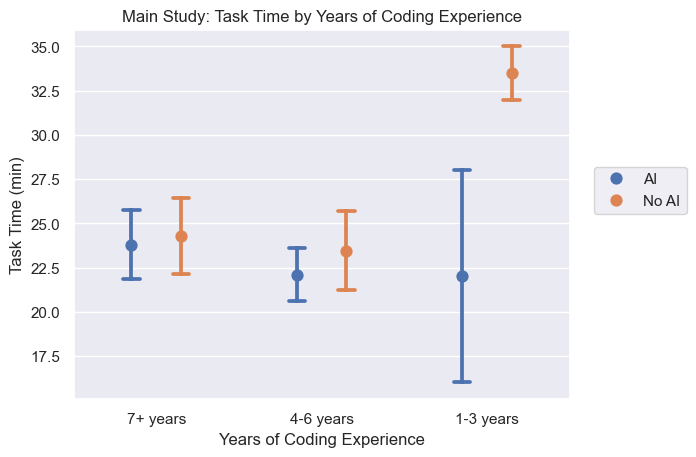

In [71]:
# TaskTime vs QuizScore
sns.pointplot(data=df, x='CodingExpertiseAll', y='TaskTime', hue='Condition', 
              errorbar="se", capsize=0.1, linestyle="", dodge=0.3)
#plt.ylim(0, 30)
plt.ylabel("Task Time (min)")
plt.xlabel("Years of Coding Experience")
plt.legend(loc=(1.05, 0.5))
plt.title('Main Study: Task Time by Years of Coding Experience')

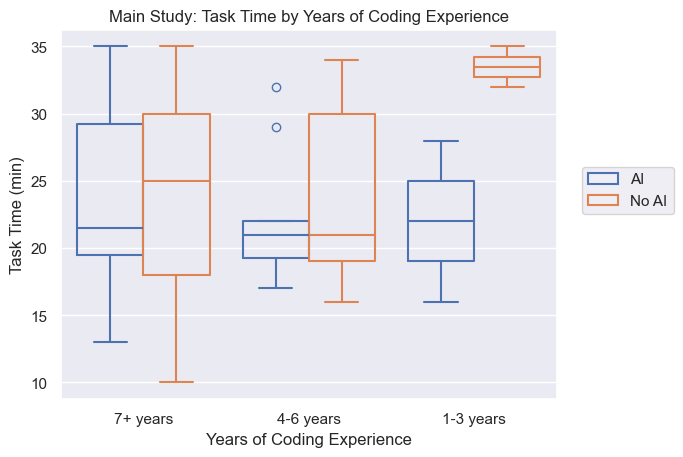

In [ ]:
# TaskTime vs QuizScore
sns.boxplot(data=df, x='CodingExpertiseAll', y='TaskTime', hue='Condition', fill=False)
#plt.ylim(0, 30)
plt.ylabel("Task Time (min)")
plt.xlabel("Years of Coding Experience")
plt.legend(loc=(1.05, 0.5))
plt.title('Main Study: Task Time by Years of Coding Experience')
plt.show()

In [ ]:
df['AI Tool Usage'] = df['HowdidyouuseAItoolsforthecodingtask?\nSelecttheoptionthatbestdescribesyourexperience:']
df['AI Usage Text'] = df['AI Tool Usage'].map({
    1: '1 - No AI',
    2: '2 - Minimal use',
    3: '3 - Occasional use', 
    4: '4 - Problem solving',
    5: '5 - Code generation',
    6: '6 - Heavy assistance',
    7: '7 - Full assistance'
})
demo_fetures = [('Age', 'Whatisyourcurrentage?'),
                ('Education', 'Whatisthehighestlevelofeducationthatyouhavecompleted?'), 
                ('Student Status', 'Areyoucurrentlyastudent?'),
                ('Coding Context', 'Inwhatcontextdoyoudomostofyourprogramming?'), 
                ('AI Tool Usage', 'AI Usage Text')
]

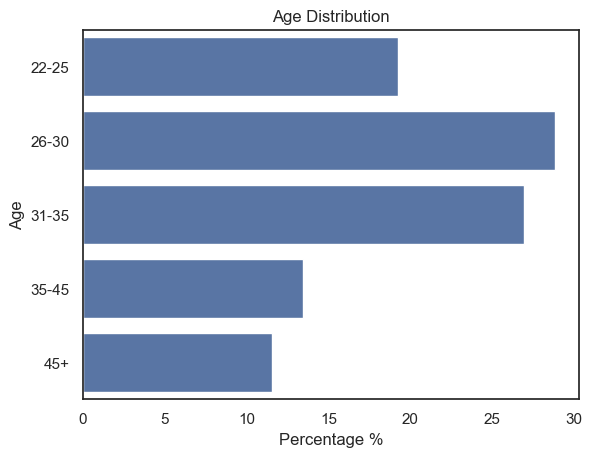

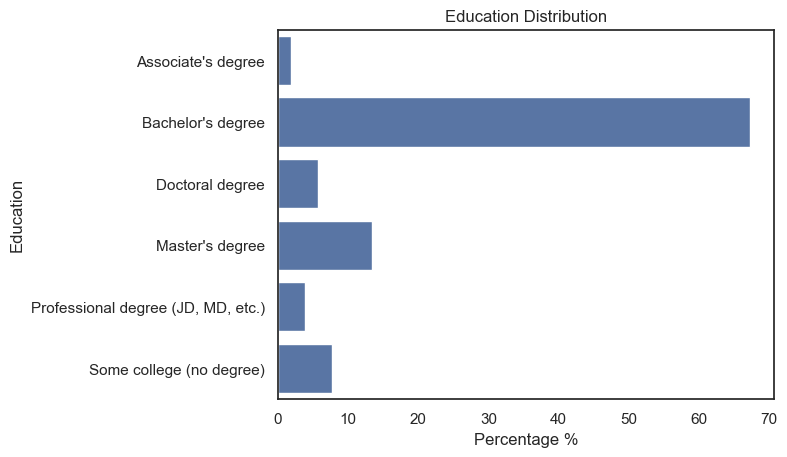

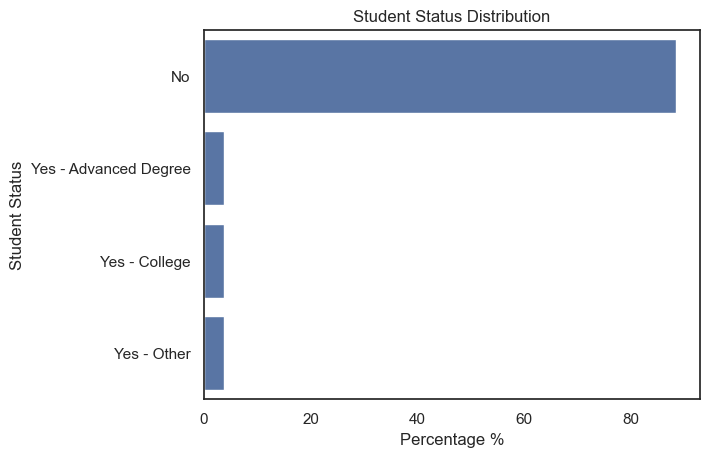

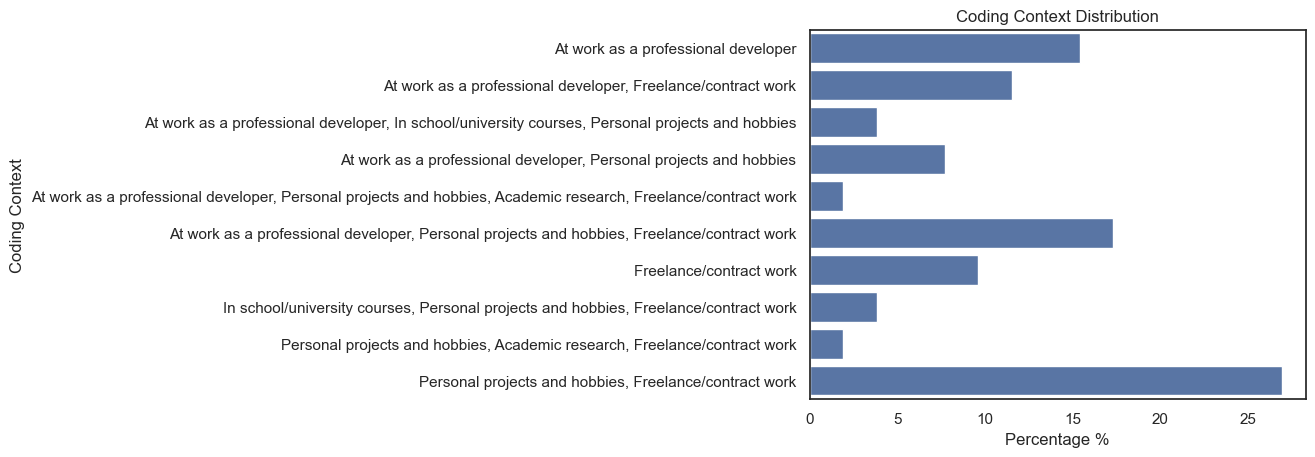

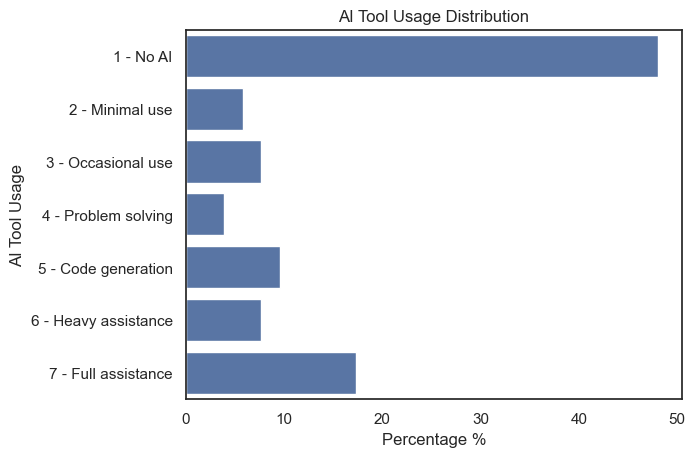

In [114]:
# demographic analysis
for key, key_name in demo_fetures:
    df[key] = df[key_name]
    count_df = df.groupby([key]).size().reset_index(name='count')
    count_df['percentage'] = 100*count_df['count'].astype(int) / count_df['count'].sum()
    sns.barplot(data=count_df, x='percentage', y=key, orient='h').set_title(f"{key} Distribution")
    plt.xlabel("Percentage %")
    plt.show()

Coding Context
Freelance/contract work                38
Personal projects and hobbies          33
At work as a professional developer    30
In school/university courses            4
Academic research                       2
Name: count, dtype: int64
107


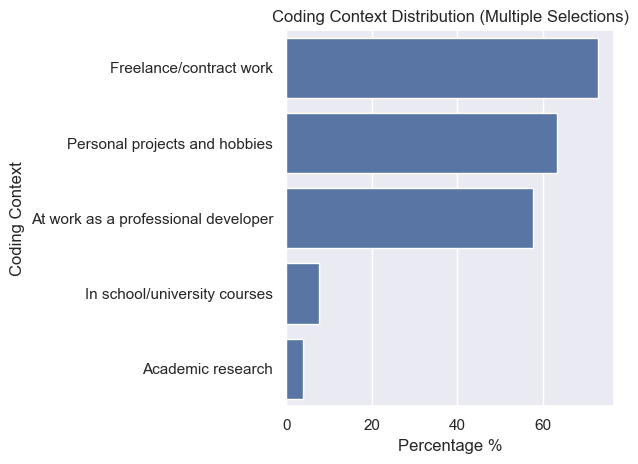

In [46]:
delimiter = ", "
exploded_df = df[key].str.split(delimiter).explode().reset_index(drop=True)
print(exploded_df.value_counts())
# Count frequency of each individual option
count_df = exploded_df.value_counts().reset_index()
count_df.columns = [key, 'count']
count_df['Percentage %'] = 100*count_df['count'].astype(int) / len(df)
print(count_df['count'].sum())
# Create the plot
plt.figure()
sns.barplot(data=count_df, x='Percentage %', y=key, orient='h')
plt.title(f"{key} Distribution (Multiple Selections)")
plt.tight_layout()
plt.show()

In [118]:
df.columns[-40:-30]

Index(['HowdidyouuseAItoolsforthecodingtask?\nSelecttheoptionthatbestdescribesyourexperience:',
       'HowusefuldidyoufindtheAItool(ifyouusedit)',
       'WhatdidyouuseAIAssistanceforinthistask?',
       'WhenyouTYPICALLYcode(outsideofthistask),whatpercentageoftimedoaskAItoexplainsomethingvsaskAItogeneratecode?\n\n(1)100%explanation-0%codegeneration\n(2)80%explanation-20%codegeneration\n(3)60%explanation-40%codegeneration\n(4)40%explanation-60%codegeneration\n(5)20%explanation-80%codegeneration\n(6)0%explanation-100%codegeneration',
       'Howmuchdoyoufeellikeyoulearnedfromthistask?',
       'Howmuchdidyouenjoythislearningtask?',
       'Howmucheffortdidyouusetocompleteeachofthetasksinthisstudy?[WarmupTask]',
       'Howmucheffortdidyouusetocompleteeachofthetasksinthisstudy?[TrioTask]',
       'Howmucheffortdidyouusetocompleteeachofthetasksinthisstudy?[PostTaskQuiz]',
       'DidyouuseAIAssistanceforthisquiz?'],
      dtype='object')

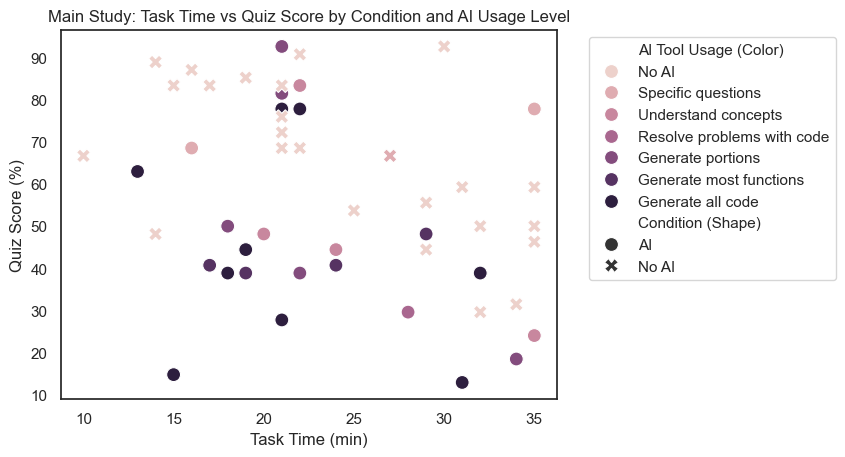

In [106]:
df['AI Tool Usage'] = df['HowdidyouuseAItoolsforthecodingtask?\nSelecttheoptionthatbestdescribesyourexperience:']
df['AI Tool Usage (Color)'] = df['AI Tool Usage']
df['Condition (Shape)'] = df['Condition']
sns.set_theme(style='white')
ax = sns.scatterplot(df, x='TaskTime', y='QuizScorePercent', hue='AI Tool Usage (Color)', style='Condition (Shape)', s=100
                )
# Get the current legend
legend = ax.get_legend()

# Create mapping for AI Tool Usage labels (string keys)
ai_label_map = {
    '1': 'No AI',
    '2': 'Specific questions',
    '3': 'Understand concepts', 
    '4': 'Resolve problems with code',
    '5': 'Generate portions',
    '6': 'Generate most functions',
    '7': 'Generate all code'
}
# Update only the AI Tool Usage labels, keep Condition labels as-is
for text in legend.get_texts():
    current_label = text.get_text()
    if current_label in ai_label_map:
        text.set_text(ai_label_map[current_label])

# Move the legend to the right of the plot
legend.set_bbox_to_anchor((1.05, 1))
legend.set_loc('upper left')
plt.xlabel('Task Time (min)')
plt.ylabel('Quiz Score (%)')
plt.title('Main Study: Task Time vs Quiz Score by Condition and AI Usage Level')

plt.show()

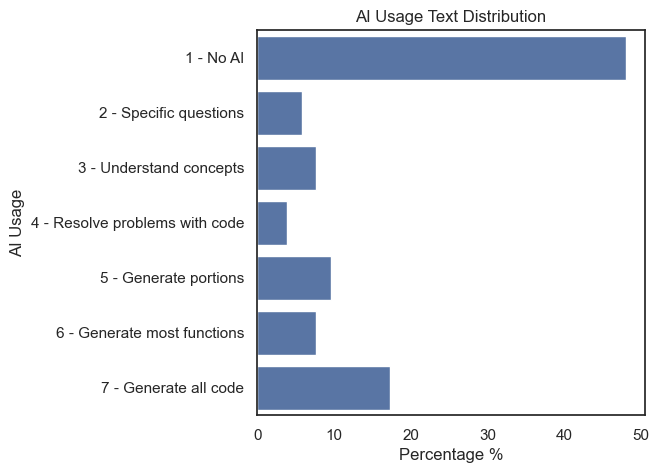

In [118]:
df['AI Usage Text'] = df['AI Tool Usage'].map({
    1: '1 - No AI',
    2: '2 - Specific questions',
    3: '3 - Understand concepts', 
    4: '4 - Resolve problems with code',
    5: '5 - Generate portions',
    6: '6 - Generate most functions',
    7: '7 - Generate all code'
})
key = 'AI Usage Text'    
count_df = df.groupby([key]).size().reset_index(name='count')
count_df['percentage'] = 100*count_df['count'].astype(int) / count_df['count'].sum()
plt.figure(figsize=(5, 5))
sns.barplot(data=count_df, x='percentage', y=key, orient='h')
plt.title(f"{key} Distribution")
plt.xlabel("Percentage %")
plt.ylabel("AI Usage")
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Enjoyment_AI vs. Enjoyment_No AI: p = 0.212
TaskLearning_AI vs. TaskLearning_No AI: p = 0.084


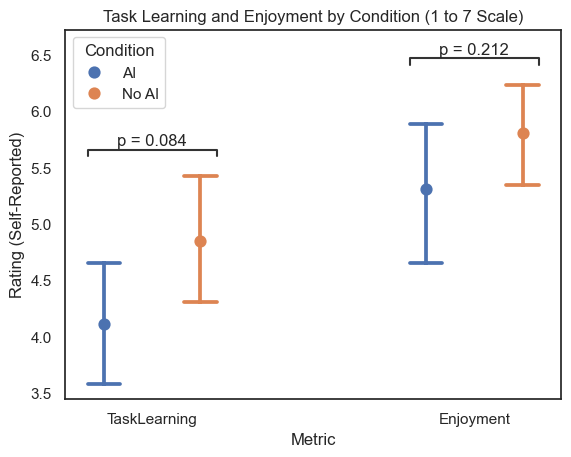

In [129]:
df['TaskLearning'] = df['Howmuchdoyoufeellikeyoulearnedfromthistask?']
df['Enjoyment'] = df['Howmuchdidyouenjoythislearningtask?']

# Melt the data to long format for plotting both metrics on the same plot
df_melted = df.melt(id_vars=['Condition'], value_vars=['TaskLearning', 'Enjoyment'], 
                    var_name='Metric', value_name='Score')

ax = sns.pointplot(data=df_melted, x='Metric', y='Score', hue='Condition', errorbar='ci', capsize=0.1, dodge=0.3, linestyle='')

pvals = []
pairs = []  
for i, outcome in enumerate(['TaskLearning', 'Enjoyment']):
    model = smf.ols(f'{outcome} ~ Treatment', data=df).fit()
    treatment_effect = model.params['Treatment']
    ci_lower, ci_upper = model.conf_int().loc['Treatment']
    p_value = model.pvalues['Treatment']
    pvals.append(format_pval(p_value))
    pairs.append(((outcome, "AI"), (outcome, "No AI")))

plotting_params = {
    'data': df_melted, 
    'hue': 'Condition', 
    'y': 'Score', 
    'x': 'Metric',
}
annotator = Annotator(ax=ax, pairs=pairs, **plotting_params)
annotator.set_custom_annotations(pvals)
annotator.annotate()


plt.title('Task Learning and Enjoyment by Condition (1 to 7 Scale)')
plt.ylabel("Rating (Self-Reported)")
plt.xlabel("Metric")
plt.legend(title='Condition')
plt.show()


In [132]:
df_melted

,Condition,Task Stage,Difficulty
0,AI,Warm Up,1
1,AI,Warm Up,3
2,AI,Warm Up,3
3,AI,Warm Up,3
4,AI,Warm Up,4
...,...,...,...
151,AI,Post Task Quiz,3
152,AI,Post Task Quiz,4
153,No AI,Post Task Quiz,3
154,No AI,Post Task Quiz,4


WarmUp
TrioTask
PostTaskQuiz
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TrioTask_AI vs. TrioTask_No AI: p = 0.093
WarmUp_AI vs. WarmUp_No AI: p = 0.041*
PostTaskQuiz_AI vs. PostTaskQuiz_No AI: p = 0.697


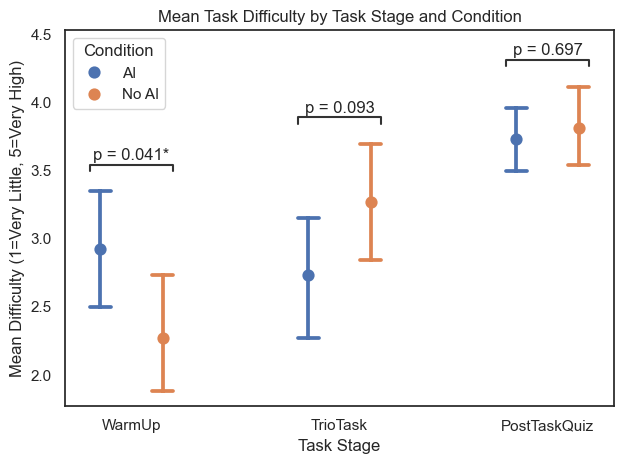

In [141]:
df['WarmUp'] = df['Howmucheffortdidyouusetocompleteeachofthetasksinthisstudy?[WarmupTask]'].map(effort_mapping)
df['TrioTask'] = df['Howmucheffortdidyouusetocompleteeachofthetasksinthisstudy?[TrioTask]'].map(effort_mapping)
df['PostTaskQuiz'] = df['Howmucheffortdidyouusetocompleteeachofthetasksinthisstudy?[PostTaskQuiz]'].map(effort_mapping)

# Convert effort levels to numeric scale
effort_mapping = {
    'Very little effort': 1,
    'Little effort': 2,
    'Moderate effort': 3,
    'High effort': 4,
    'Very high effort': 5
}

# Apply mapping to all difficulty columns
difficulty_cols = ['Task Difficulty (Warm Up)', 'Task Difficulty (Trio Task)', 'Task Difficulty (Post Task Quiz)']
for col in difficulty_cols:
    df[col + '_numeric'] = df[col].map(effort_mapping)

# Melt the numeric data to long format for plotting
numeric_cols = [col + '_numeric' for col in difficulty_cols]
df_melted = df.melt(id_vars=['Condition'], value_vars=numeric_cols, 
                    var_name='Task Stage', value_name='Difficulty')

# Clean up task type names
df_melted['Task Stage'] = df_melted['Task Stage'].str.replace('_numeric', '').str.replace('Task Difficulty (', '').str.replace(')', '')
df_melted['Task Stage'] = df_melted['Task Stage'].str.replace(' ', '')
# Create the plot
plt.figure()
ax = sns.pointplot(data=df_melted, x='Task Stage', y='Difficulty', hue='Condition', 
            errorbar='ci', capsize=0.1, dodge=0.3, linestyle='')
plt.title('Mean Task Difficulty by Task Stage and Condition')
plt.ylabel('Mean Difficulty (1=Very Little, 5=Very High)')

pvals = []
pairs = []  
for i, outcome in enumerate(df_melted['Task Stage'].unique()):
    print(outcome)
    model = smf.ols(f'{outcome} ~ Treatment', data=df).fit()
    treatment_effect = model.params['Treatment']
    ci_lower, ci_upper = model.conf_int().loc['Treatment']
    p_value = model.pvalues['Treatment']
    pvals.append(format_pval(p_value))
    pairs.append(((outcome, "AI"), (outcome, "No AI")))

plotting_params = {
    'data': df_melted, 
    'hue': 'Condition', 
    'y': 'Difficulty', 
    'x': 'Task Stage',
}
annotator = Annotator(ax=ax, pairs=pairs, **plotting_params)
annotator.set_custom_annotations(pvals)
annotator.annotate()

plt.tight_layout()
plt.show()


In [138]:
[c for c in df.columns if c.startswith('Q')]

['QuizScore',
 'Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q8',
 'Q9',
 'Q10',
 'Q11',
 'Q12',
 'Q13',
 'Q14',
 'Q15',
 'QuizScorePercent']

In [93]:
# Question Type Analysis: 
def get_question_score(qid : str) -> int: 
    if qid in ['Q1', 'Q2']: 
        return 1
    elif qid in ['Q15']: 
        return 3
    else: 
        return 2
    
subarea_map = {
    'Task1': ['Q1', 'Q4', 'Q5', 'Q8', 'Q9', 'Q11', 'Q12', 'Q14', 'Q15'], 
    'Task2': ['Q2', 'Q3', 'Q6', 'Q10', 'Q13'], 
    'Conceptual': ['Q1', 'Q2','Q3', 'Q14', 'Q15'], 
    'Debugging': ['Q8', 'Q10', 'Q11', 'Q12'], 
    'CodeReading': ['Q3', 'Q4', 'Q5', 'Q6', 'Q9', 'Q13'], 
}

In [94]:
subarea_df = df.copy() 

for key, value in subarea_map.items():
    total_score = subarea_df[value].astype(int).sum(axis=1)
    max_score = np.sum([get_question_score(qid) for qid in value])
    subarea_df[f'{key}Score'] = 100 * total_score / max_score 
    

In [91]:
subarea_df.head()

,STATUS,Condition,Respondent,FormTimer⏱️,WarmupTaskTime,TaskTime,TasksCompleted,TimePerTask,QuizScore,WorkerID,...,QuizScorePercent,CodingExpertiseAll,CodingExpertise,CodingExpertiseBin,Treatment,Task1Score,Task2Score,ConceptualScore,DebuggingScore,Code ReadingScore
0,COMPLETED,AI,YKDNEPQ3Z9Z2,Late (+ 4m 56s),4.0,21.0,2.0,10.5,21.0,YKDNEPQ3Z9Z2,...,77.777778,7+ years,3,7+ years,0,88.888889,55.555556,66.666667,100.0,58.333333
1,COMPLETED,AI,2X46QAFX6YTE,In time (30m 10s),12.0,19.0,2.0,9.5,10.5,2X46QAFX6YTE,...,38.888889,4-6 years,2,<7 years,0,55.555556,0.000000,22.222222,50.0,33.333333
2,COMPLETED,AI,ENZXQJ2RNAJ2,In time (22m 20s),7.0,16.0,2.0,8.0,18.5,ENZXQJ2RNAJ2,...,68.518519,1-3 years,1,<7 years,0,61.111111,77.777778,66.666667,75.0,66.666667
3,COMPLETED,AI,XVPDG3TNF7AN,In time (28m 48s),5.0,22.0,2.0,11.0,22.5,XVPDG3TNF7AN,...,83.333333,7+ years,3,7+ years,0,83.333333,77.777778,77.777778,87.5,75.000000
4,COMPLETED,AI,26E3V7XCFPK7,Late (+ 1m 32s),9.0,35.0,2.0,17.5,21.0,26e3v7xcfpk7,...,77.777778,7+ years,3,7+ years,0,88.888889,55.555556,55.555556,75.0,83.333333


Task1 Task1Score
Task2 Task2Score
Conceptual ConceptualScore
Debugging DebuggingScore
CodeReading CodeReadingScore
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Task2Score_AI vs. Task2Score_No AI: p = 0.065
Task1Score_AI vs. Task1Score_No AI: p = 0.014*
ConceptualScore_AI vs. ConceptualScore_No AI: p = 0.023*
DebuggingScore_AI vs. DebuggingScore_No AI: p = 0.019*
CodeReadingScore_AI vs. CodeReadingScore_No AI: p = 0.118


/var/folders/jc/ctcxyx_55yqb7m0dg7sj4clm0000gn/T/ipykernel_79782/1060034930.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text().replace('Score', '') for label in ax.get_xticklabels()])


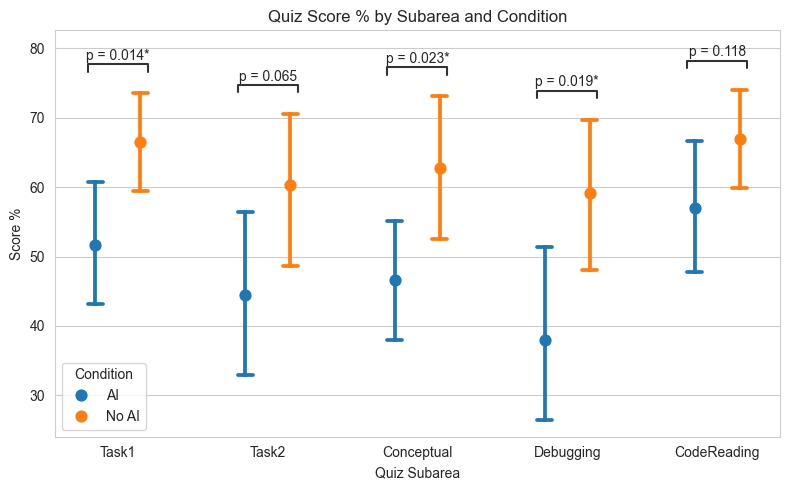

In [103]:
# Melt the subarea data to long format for plotting all subareas together
subarea_cols = [f'{key}Score' for key in subarea_map.keys()]
subarea_df_melted = subarea_df.melt(id_vars=['Condition'], value_vars=subarea_cols, 
                                    var_name='Subarea', value_name='Score %')

# Clean up subarea names (remove ' Score %' suffix)
subarea_df_melted['Subarea'] = subarea_df_melted['Subarea'].str.replace(' Score %', '')

# Create the combined plot
plt.figure(figsize=(8, 5))
ax = sns.pointplot(data=subarea_df_melted, x='Subarea', y='Score %', hue='Condition', 
            errorbar='ci', capsize=0.1, linestyle='', dodge=0.3)
pvals = []
pairs = []  
for i, outcome in enumerate(subarea_map.keys()):
    outcome_str = f'{outcome}Score'
    print(outcome, outcome_str)
    model = smf.ols(f'{outcome_str} ~ Treatment', data=subarea_df).fit()
    treatment_effect = model.params['Treatment']
    ci_lower, ci_upper = model.conf_int().loc['Treatment']
    p_value = model.pvalues['Treatment']
    pvals.append(format_pval(p_value))
    pairs.append(((outcome_str, "AI"), (outcome_str, "No AI")))

plotting_params = {
    'data': subarea_df_melted, 
    'hue': 'Condition', 
    'y': 'Score %', 
    'x': 'Subarea',
}
annotator = Annotator(ax=ax, pairs=pairs, **plotting_params)
annotator.set_custom_annotations(pvals)
annotator.annotate()

plt.title('Quiz Score % by Subarea and Condition')
plt.ylabel('Score %')
plt.xlabel('Quiz Subarea')
# Remove 'Score' suffix from x-axis labels
ax.set_xticklabels([label.get_text().replace('Score', '') for label in ax.get_xticklabels()])

plt.tight_layout()
plt.show()